<a href="https://colab.research.google.com/github/Waleed850/Coding-Code/blob/main/Crop_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Preprocessing**

In [ ]:
! git clone https://github.com/Waleed850/Coding-Code.git

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Preprocessing**

In [ ]:
import numpy as np
from osgeo import gdal, gdal_array
import pandas as pd
import operator
import gc

In [ ]:
# Load ROI data
roi_ds = gdal.Open('/content/process.tif', gdal.GA_ReadOnly)
roi = roi_ds.GetRasterBand(1).ReadAsArray()

In [ ]:
# Identify top classes
classes = np.unique(roi)
class_counts = {c: (roi == c).sum() for c in classes}
sorted_classes = sorted(class_counts.items(), key=operator.itemgetter(1), reverse=True)
top_classes = [c for c, count in sorted_classes if c != 255][:5]  # Exclude class 255 and take top 5

In [ ]:
# Print class info
print("Top 5 classes and their pixel counts:")
for c in top_classes:
    print(f"Class {c} contains {class_counts[c]} pixels")

Top 5 classes and their pixel counts:
Class 28836 contains 1433243 pixels
Class 32768 contains 1082954 pixels
Class 24904 contains 788630 pixels
Class 20316 contains 430770 pixels
Class 16384 contains 192103 pixels


In [ ]:
# Get classification labels
labels = np.unique(roi[roi > 0])

In [ ]:
# Images to process
images = [
    '/content/process_1.tif',
    '/content/process_2.tif',
    '/content/process_3.tif']

In [ ]:
# Dataframe to hold all data
final = pd.DataFrame()

In [ ]:
# Process each class
for c in top_classes:
    print(f"Processing class {c}")
    class_data = []

    for img_path in images:
        print(f"Reading image: {img_path}")
        train_ds = gdal.Open(img_path, gdal.GA_ReadOnly)

        img_b1 = np.zeros((train_ds.RasterYSize, train_ds.RasterXSize, train_ds.RasterCount),
                          gdal_array.GDALTypeCodeToNumericTypeCode(train_ds.GetRasterBand(1).DataType))

        for b in range(img_b1.shape[2]):
            img_b1[:, :, b] = train_ds.GetRasterBand(b + 1).ReadAsArray()

        # Resize ROI to match image dimensions
        roi_resized = np.resize(roi, (img_b1.shape[0], img_b1.shape[1]))

        mask = (roi_resized == c)
        mask.shape != img_b1[:, :, 0].shape

        for b in range(img_b1.shape[2]):
            # Collect data for the class
            class_data.append(img_b1[mask, b].flatten())

    # Ensure all arrays in class_data have the same length
    min_length = min(map(len, class_data))
    class_data = [arr[:min_length] for arr in class_data]

    # Convert to DataFrame
    class_df = pd.DataFrame(np.column_stack(class_data))
    class_df['class'] = c

    # Append to final dataset
    final = pd.concat([final, class_df], axis=0)

    gc.collect()

# Reset index
final.reset_index(drop=True, inplace=True)

Processing class 28836
Reading image: /content/process_1.tif
Reading image: /content/process_2.tif
Reading image: /content/process_3.tif
Processing class 32768
Reading image: /content/process_1.tif
Reading image: /content/process_2.tif
Reading image: /content/process_3.tif
Processing class 24904
Reading image: /content/process_1.tif
Reading image: /content/process_2.tif
Reading image: /content/process_3.tif
Processing class 20316
Reading image: /content/process_1.tif
Reading image: /content/process_2.tif
Reading image: /content/process_3.tif
Processing class 16384
Reading image: /content/process_1.tif
Reading image: /content/process_2.tif
Reading image: /content/process_3.tif


In [ ]:
final

,0,1,2,3,4,5,6,class
0,30372,24194,20012,24592,14025,9912,3965,28836
1,26692,22597,18649,18481,11026,7438,2975,28836
2,27792,22885,19522,22479,12452,8618,3447,28836
3,29336,23036,21395,18727,10371,7373,2949,28836
4,29703,24101,21583,20251,11370,7815,3126,28836
...,...,...,...,...,...,...,...,...
3925566,26560,22436,19911,31179,12370,9273,3709,16384
3925567,24259,21299,19297,31900,12550,8913,3565,16384
3925568,36533,31021,28039,38158,16286,12091,4836,16384
3925569,37748,31936,29191,46088,19694,15565,6226,16384


In [ ]:
final.columns = ['col_'+str(i) for i in range(8)]

In [ ]:
final.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,30372,24194,20012,24592,14025,9912,3965,28836
1,26692,22597,18649,18481,11026,7438,2975,28836
2,27792,22885,19522,22479,12452,8618,3447,28836
3,29336,23036,21395,18727,10371,7373,2949,28836
4,29703,24101,21583,20251,11370,7815,3126,28836


In [ ]:
final.to_csv("Dataset123.csv",index=False)

**Crop Classification Model**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras import regularizers

In [ ]:
# Load the dataset
final = pd.read_csv("/content/Dataset123.csv")

In [ ]:
labels = final.iloc[:,-1]

In [ ]:
data = final.drop(final.columns[7],axis=1)

In [ ]:
data.shape

(3925571, 7)

In [ ]:
# Separate features and labels
data = final.iloc[:, :-1]
labels = final['col_7']

In [ ]:
# Encode class values as integers
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(labels)
dummy_y = to_categorical(encoded_Y, num_classes=5)

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(data, dummy_y, test_size=0.33, random_state=42, shuffle=True)


In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Build the model
model = Sequential()
model.add(Dense(200, input_shape=(X_train.shape[1],), activation='relu',
                kernel_regularizer=regularizers.l2(1e-5),
                kernel_initializer='glorot_normal', bias_initializer='zeros'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'], validation= 'False')

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, shuffle=True)

In [ ]:
# Evaluate the model
score = model.evaluate(X_test, y_test, batch_size=32)
print("\n%s: %.2f%%" % (model.metrics_names[1], score[1] * 100))

40483/40483 [==============================] - 95s 2ms/step - loss: 0.0480 - accuracy: 0.9816

accuracy: 98.16%


In [ ]:
final

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,30372,24194,20012,24592,14025.0,9912.0,3965.0,28836.0
1,26692,22597,18649,18481,11026.0,7438.0,2975.0,28836.0
2,27792,22885,19522,22479,12452.0,8618.0,3447.0,28836.0
3,29336,23036,21395,18727,10371.0,7373.0,2949.0,28836.0
4,29703,24101,21583,20251,11370.0,7815.0,3126.0,28836.0
...,...,...,...,...,...,...,...,...
247213,28211,24467,20518,23446,13124.0,10666.0,4266.0,28836.0
247214,28282,23930,20746,40468,23544.0,17564.0,7025.0,28836.0
247215,28403,23658,21913,43516,24691.0,18219.0,7287.0,28836.0
247216,31902,27092,24669,31965,19071.0,13124.0,5249.0,28836.0


In [ ]:
model.save('crop_classification_model.h5')

**Normalized Difference Vegetation Index (NDVI)**

In [ ]:
import numpy as np
import pandas as pd
from osgeo import gdal, gdal_array
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
import keras.utils

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 16]

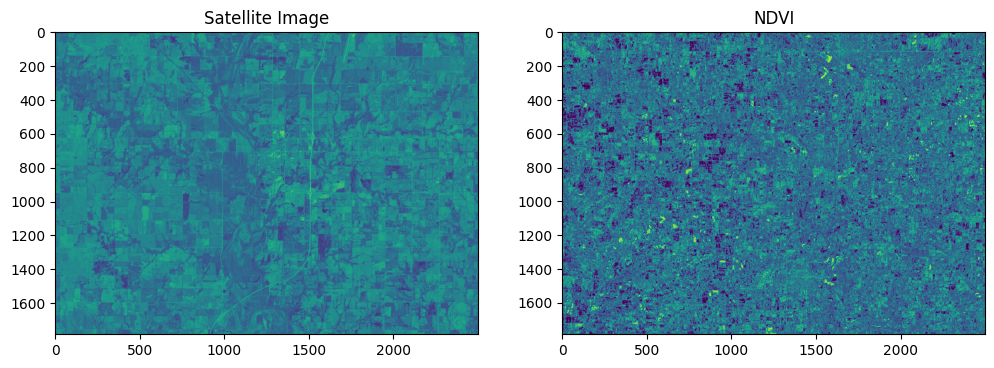

In [ ]:
# Read in our image and ROI image
img_ds = gdal.Open('/content/process_1.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('/content/process.tif', gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 1])#, cmap=plt.cm.Spectral)
plt.title('Satellite Image')

plt.subplot(122)
plt.imshow(roi)#, cmap=plt.cm.Spectral)
plt.title('NDVI')

plt.show()

In [ ]:
#how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))

We have 3131694 samples
The training data include 12 classes: [ 20  41  72  92 113 133 164 184 205 215 236 255]


In [ ]:
# Read final dataset
final = pd.read_csv("/content/Dataset123.csv")

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final.iloc[:,:-1],final.iloc[:,-1], test_size=0.33, random_state=42)

In [ ]:
final.columns = ['col_'+str(i) for i in range(8)]

In [ ]:
final.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,30372,24194,20012,24592,14025,9912,3965,28836
1,26692,22597,18649,18481,11026,7438,2975,28836
2,27792,22885,19522,22479,12452,8618,3447,28836
3,29336,23036,21395,18727,10371,7373,2949,28836
4,29703,24101,21583,20251,11370,7815,3126,28836


In [ ]:
# Prepare NDVI DataFrame
ndvi_df = pd.DataFrame(pd.Series(final.iloc[:, -1]), columns=['col_7'])
mul = [i * 5 for i in range(11)]

In [ ]:
# Define the model
model = Sequential([
    Conv1D(32, kernel_size=2, strides=1, activation='relu', input_shape=(7, 1)),
    MaxPooling1D(pool_size=2, strides=2),
    Conv1D(64, kernel_size=2, strides=1, activation='relu'),
    MaxPooling1D(pool_size=2, strides=2),
    Flatten(),
    Dense(1000, activation='relu'),
    Dense(5, activation='softmax')
])

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Prepare training data
X_train = final.iloc[:, :-1].values
y_train = final.iloc[:, -1].values

In [ ]:
# Convert labels to one-hot encoding
encoder = LabelEncoder()
encoded_y = encoder.fit_transform(y_train)
dummy_y = keras.utils.to_categorical(encoded_y)

In [ ]:
# Train the model
history = model.fit(X_train, dummy_y, epochs=5, batch_size=32, shuffle=True)

In [ ]:
model.save('NVDI_model.h5')

**Classification**

In [ ]:
from keras.models import load_model

# Load the Crop Classification Model
crop_model = load_model('/content/crop_classification_model.h5')

# Load the NDVI Model
ndvi_model = load_model('/content/NVDI_model.h5')


In [ ]:
# Preprocess input data for Crop Classification Model
X_crop = scaler.transform(final.iloc[:, :-1])  # Assuming 'scaler' is the StandardScaler used for training the crop classification model

# Preprocess input data for NDVI Model (assuming it's in the format of final dataset)
X_ndvi = final.iloc[:, :-1].values


In [ ]:
# Predict crop class using Crop Classification Model
crop_class_prediction = crop_model.predict(X_crop)

# Calculate NDVI using NDVI Model
ndvi_prediction = ndvi_model.predict(X_ndvi)


122675/122675 [==============================] - 269s 2ms/step


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

# Load your pre-trained models
crop_classification_model = load_model('/content/crop_classification_model.h5')
ndvi_model = load_model('/content/NVDI_model.h5')

# Load the dataset and scaler
final = pd.read_csv("/content/Dataset123.csv")
scaler = StandardScaler().fit(final.iloc[:, :-1].values)  # Fit the scaler on the dataset

# Load the original satellite image (adjust the path and method as per your context)
img_ds = gdal.Open('/content/process.tif', gdal.GA_ReadOnly)
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

# Assuming you have your encoder used during the training phase
encoder = LabelEncoder()
encoder.fit(final['col_7'])  # Fit the encoder on the target labels during training
crop_classes = encoder.inverse_transform(np.argmax(crop_class_prediction, axis=1))


In [ ]:
print("Image shape:", img.shape)


Image shape: (1786, 2500, 3)


In [ ]:
# Calculate NDVI
def calculate_ndvi(nir_band, red_band):
    return (nir_band - red_band) / (nir_band + red_band)

nir_band = img[:, :, 0]  # Assuming NIR is in the 4th band
red_band = img[:, :, 1]  # Assuming Red is in the 3rd band
ndvi = calculate_ndvi(nir_band, red_band)

# Add NDVI to the final DataFrame (for visualization purposes)
ndvi_df = final.copy()
ndvi_df['NDVI'] = ndvi.flatten()[:ndvi_df.shape[0]]  # Match NDVI values to the final DataFrame rows

# Create a pivot table for average NDVI
pivot_table = pd.pivot_table(ndvi_df, index=["col_7"])

# Display the head of the DataFrame
print(ndvi_df.head(10))

   col_0  col_1  col_2  col_3  col_4  col_5  col_6  col_7      NDVI
0  30372  24194  20012  24592  14025   9912   3965  28836  9.999809
1  26692  22597  18649  18481  11026   7438   2975  28836  4.000076
2  27792  22885  19522  22479  12452   8618   3447  28836  9.999809
3  29336  23036  21395  18727  10371   7373   2949  28836  4.000076
4  29703  24101  21583  20251  11370   7815   3126  28836  9.999809
5  31515  25545  22467  20136  11092   7537   3015  28836  4.000076
6  31441  26216  22353  19857  10797   7471   2988  28836  4.000076
7  31774  25638  22612  19939  11174   7340   2936  28836  0.043487
8  31926  25586  22211  19726  10912   7258   2903  28836  0.814441
9  32346  26972  23119  19235  10437   7160   2864  28836  4.000076


Text(0.5, 1.0, 'NDVI')

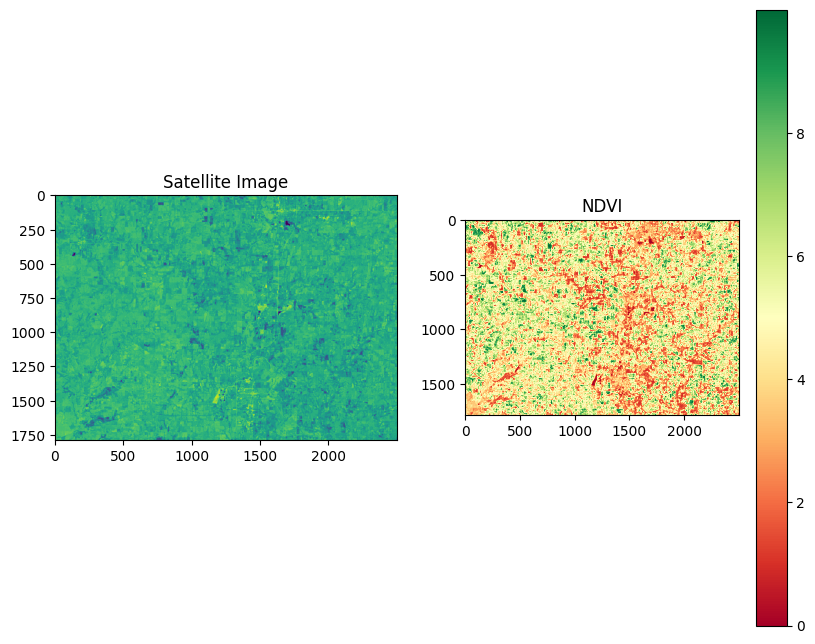

In [ ]:
plt.figure(figsize=(15, 8))

# Visualize the original satellite image
plt.subplot(1, 3, 1)
plt.imshow(img[:, :, 1])
plt.title('Satellite Image')

# Visualize the NDVI
plt.subplot(1, 3, 2)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI')

